# Clustering and topics analysis

In this part of the project, we focus on analyzing the data that we collected and transformed in the previous steps. As a reminder, our main questions that motivated this project were:

- What are the groups that Members of Parliament form based on the collected voting outcomes?
- Can we suggest any alliances based on these outcomes?
- What topics could these alliances be formed over?

The following notebook is divided into several key steps:

<a href="#cleaning" style="font-size: 26px;">Cleaning vote_info dataframe</a>

We begin by cleaning up the vote_info dataframe to ensure that vote IDs are consistent across both dataframes and that the time is transformed into a convenient Pandas datetime format.

<a href="#dimensionality" style="font-size: 26px;">Dimensionality reduction</a>

Next, we reduce the dimensionality of the data to eliminate bias in the analysis. To do this, we exclude votings related to numerous amendments, which accounted for more than 70% of the total votings. We focus only on fully ready legislations.

<a href="#clustering" style="font-size: 26px;">Clustering</a>

To determine the optimal grouping for members of parliament, we fit the KMeans algorithm multiple times with different configurations and evaluate the clusters using the average silhouette score. This helps to identify the most effective way to group the MPs in a meaningful way for the analysis.

<a href='#topics' style="font-size: 26px;">Identifying crucial topics that bind opposition parties</a>

Finally, we investigate the topics that could constitute the big alliance of opposition parties using natural language processing techniques. To achieve this, we take two different approaches: finding keywords that best describe those topics and extracting legislation names directly.

## Table of contents
<ul>
  <li><a href="#cleaning">Cleaning votes_info</a></li>
  <li><a href="#dimensionality">Dimensionality reduction</a></li>
  <li><a href="#clustering">Clustering</a></li>
  <li><a href='#topics'>Identifying crucial topics that bind opposition parties<a></li>
</ul>

In [1]:
import os
import time

# Data processing tools
import pandas as pd
import numpy as np
# Clustering and evaluation tools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
# Visualisation tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# NLP tools
import nltk
import morfeusz2
from sklearn.feature_extraction.text import TfidfVectorizer


local_path = '/home/milosh-dr/code/MPs'

# Read collected and transformed data from the files 
df = pd.read_csv(os.path.join(local_path, 'transformed_results.csv'))
votes_info = pd.read_csv('votes_info.csv')

In [2]:
df.head()

,Party,MPS,62/1,62/2,62/3,62/4,62/5,62/6,62/7,62/8,...,46/57,46/58,46/59,46/60,46/61,46/62,46/63,46/64,46/65,46/66
0,PiS,Adamczyk Andrzej,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,PiS,Andruszkiewicz Adam,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,PiS,Andzel Waldemar,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
3,PiS,Ardanowski Jan Krzysztof,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4,PiS,Arent Iwona,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [3]:
votes_info.head()

,session_no,session_url,date,vote_no,vote_url,vote_time,vote_topic,vote_type
0,62,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,28 września 2022 r.,1,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,12:39:39,Pkt. 3 Sprawozdanie Komisji o uchwale Senatu w...,poprawki nr 1-7 i 9
1,62,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,28 września 2022 r.,2,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,12:40:10,Pkt. 3 Sprawozdanie Komisji o uchwale Senatu w...,poprawka 8
2,62,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,28 września 2022 r.,3,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,12:40:33,Pkt. 3 Sprawozdanie Komisji o uchwale Senatu w...,poprawki nr 10-11
3,62,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,28 września 2022 r.,4,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,12:41:31,Pkt. 2 Pierwsze czytanie poselskiego projektu ...,wniosek o odrzucenie projektu w pierwszym czyt...
4,62,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,28 września 2022 r.,5,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,12:42:25,62. posiedzenie Sejmu Rzeczypospolitej Polskie...,wniosek o zastosowanie art. 39 ust. 3 regulami...


The data we collected is divided into two dataframes. The first dataframe, *df*, contains a row for each Member of Parliament and provides information on his/her name, party affiliation, and voting outcome for each legislation. The voting outcome is represented by three possible values: 1 for voting in favor of a legislation, 0 for voting against it, and 0.5 for abstaining from voting.

The second dataframe, called *votes_info*, provides information about each voting event, including the time and date it occurred, its ID, the corresponding URL on parliament's website, and its topic and type. However, before we can use this data for our analysis, we need to clean it up to ensure that the voting IDs match those in the first dataframe. We also need to merge the separate date and time columns into a single datetime column for convenience.

<a id='cleaning'></a>

## Cleaning votes_info

Let's restore *vote_id* column to match the format we use in **df**

In [4]:
votes_info['vote_id'] = votes_info['session_no'].astype('str') + '/' + votes_info['vote_no'].astype('str')

We'll now convert the *date* and *vote_time* columns in the **votes_info** dataframe to pandas datetime format using regular expressions. This will allow us to perform time-based operations and analysis on the data. Lastly, we can delete URLs, as they are irrelevant for the analysis.

In [5]:

# Create mapping for months
mapping = {
    'stycz\w+':'01',
    'lut\w+':'02',
    'mar\w+':'03',
    'kwie\w+':'04',
    'maj\w+':'05',
    'czerw\w+':'06',
    'lip\w+':'07',
    'sierp\w+':'08',
    'wrze\w+':'09',
    'paździer\w+':'10',
    'listop\w+':'11',
    'grud\w+':'12'
}

# Replace months with their numeric representations
for verbose, numeric in mapping.items():
    votes_info['date'] = votes_info['date'].str.replace(f'(\d\d?)\s?({verbose})\s?(\d\d\d\d)\s?r\.', f'\\1-{numeric}-\\3', regex=True)

# Convert the information from 'date' and 'vote_time' columns into datetime format 'YYYY-MM-DD HH:MM:SS'
votes_info['time'] = pd.to_datetime(votes_info['date'] + ' ' + votes_info['vote_time'], format='%d-%m-%Y %H:%M:%S')

# Get rid of columns, that won't be used any more
votes_info.drop(['session_no', 'vote_no', 'date', 'vote_time', 'session_url', 'vote_url'], axis=1, inplace=True)

votes_info.head()

,vote_topic,vote_type,vote_id,time
0,Pkt. 3 Sprawozdanie Komisji o uchwale Senatu w...,poprawki nr 1-7 i 9,62/1,2022-09-28 12:39:39
1,Pkt. 3 Sprawozdanie Komisji o uchwale Senatu w...,poprawka 8,62/2,2022-09-28 12:40:10
2,Pkt. 3 Sprawozdanie Komisji o uchwale Senatu w...,poprawki nr 10-11,62/3,2022-09-28 12:40:33
3,Pkt. 2 Pierwsze czytanie poselskiego projektu ...,wniosek o odrzucenie projektu w pierwszym czyt...,62/4,2022-09-28 12:41:31
4,62. posiedzenie Sejmu Rzeczypospolitej Polskie...,wniosek o zastosowanie art. 39 ust. 3 regulami...,62/5,2022-09-28 12:42:25


<a id='dimensionality'></a>

## Dimensionality reduction

Our feature vectors have above 1700 dimensions. Let's explore what we could do to reduce this number.

A brief look into the *vote_type* column makes it clear that we can easily group votes into several major categories. Again we'll use regular expressions and add *vote_category* column to our dataframe.

In [6]:
mapping = {
    'odrzuce': 'odrzucenie',
    'poprawk': 'poprawki',
    'głosowanie nad całością': 'głosowanie za',
    'mniejszości': 'wniosek mniejszości',
    'odpowiedzialności karnej': 'odpowiedzialność karna',
    'inne': 'inne'
}
votes_info['vote_category'] = (votes_info.vote_type
     .str.extract('(odrzuce|poprawk|głosowanie nad całością|mniejszości|odpowiedzialności karnej)', expand=False)
     .fillna('inne')
     .map(mapping))

votes_info['vote_category'].value_counts()

poprawki                  1220
głosowanie za              173
inne                       169
wniosek mniejszości         85
odrzucenie                  61
odpowiedzialność karna       6
Name: vote_category, dtype: int64

The majority of votings relate to amendments, with only around 230 being for or against the entire project. To get a clearer picture of MPs' preferences, we should focus on these vote IDs. This will help us distill our dataframe and reduce noise in the data.

In [22]:
# Create a list of selected categories
selection = ['głosowanie za', 'odrzucenie', 'odpowiedzialność karna']
# Select only those votings that have their category included in the selection
selected_votes = votes_info[votes_info['vote_category'].isin(selection)]
vote_ids = selected_votes['vote_id'].tolist()
# Create a list of columns for new dataframe
new_cols = ['MPS', 'Party']
new_cols.extend(vote_ids)

df_short = df[new_cols]
df_short.head()

,MPS,Party,62/4,62/9,62/10,62/16,62/17,62/22,62/24,62/26,...,46/10,46/12,46/29,46/36,46/43,46/47,46/51,46/60,46/61,46/62
0,Adamczyk Andrzej,PiS,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,Andruszkiewicz Adam,PiS,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,Andzel Waldemar,PiS,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Ardanowski Jan Krzysztof,PiS,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,Arent Iwona,PiS,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [8]:
# Uncomment when ready

# df_short.to_csv('transformed_results_short.csv', index=False)

<a id='clustering'></a>

## Clustering

To begin our analysis, we will use the KMeans algorithm and determine the optimal number of clusters to describe the given data. We will consider a range of 2 to 11 clusters. This will provide us with some initial insights into the alliances within the parliament. Going beyond 11 clusters is not required, as this number accurately represents the number of political parties in the parliament, including members who are not affiliated with a specific party, which are represented as "niez." in the data.

We will be evaluating our clustering solutions using silhouette score. It provides a measure of how close each data point is to the data points in its own cluster compared to the data points in other clusters.

,MPS,Party,clusters_KMeans_2,clusters_KMeans_3,clusters_KMeans_4,clusters_KMeans_5,clusters_KMeans_7,clusters_KMeans_9,clusters_KMeans_11
0,Adamczyk Andrzej,PiS,1,1,0,1,0,7,0
1,Andruszkiewicz Adam,PiS,1,1,0,1,0,7,0
2,Andzel Waldemar,PiS,1,1,0,1,0,7,0
3,Ardanowski Jan Krzysztof,PiS,1,1,0,1,0,7,0
4,Arent Iwona,PiS,1,1,0,1,0,7,0


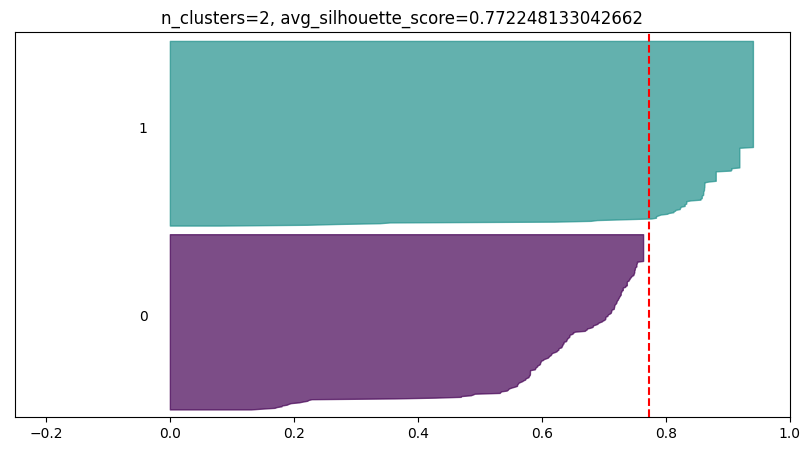

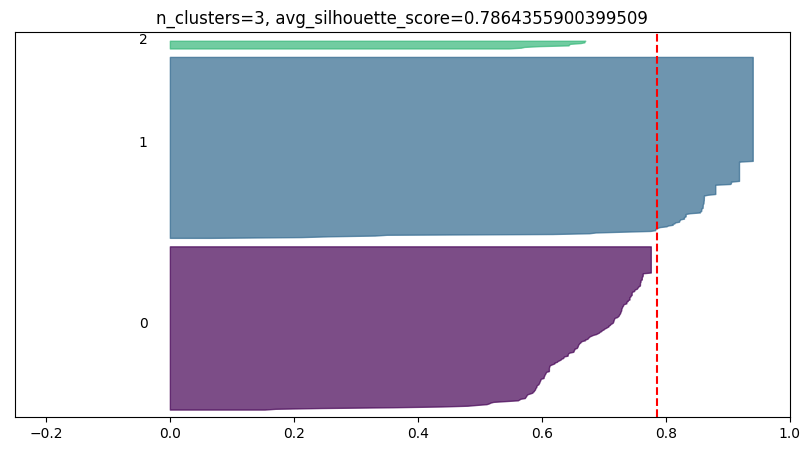

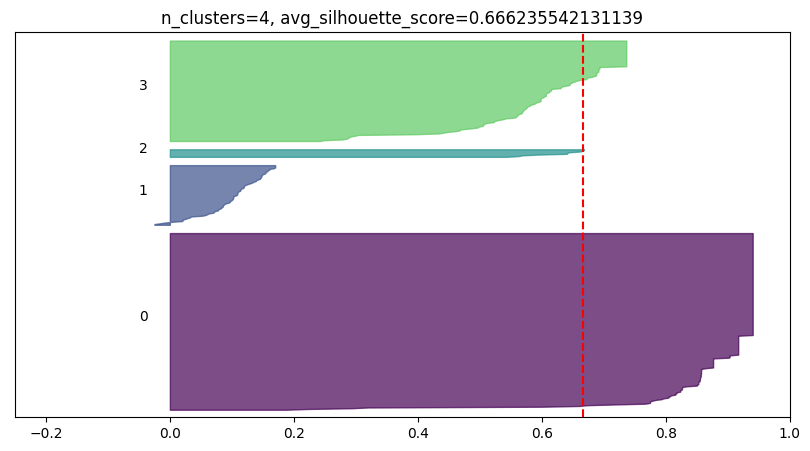

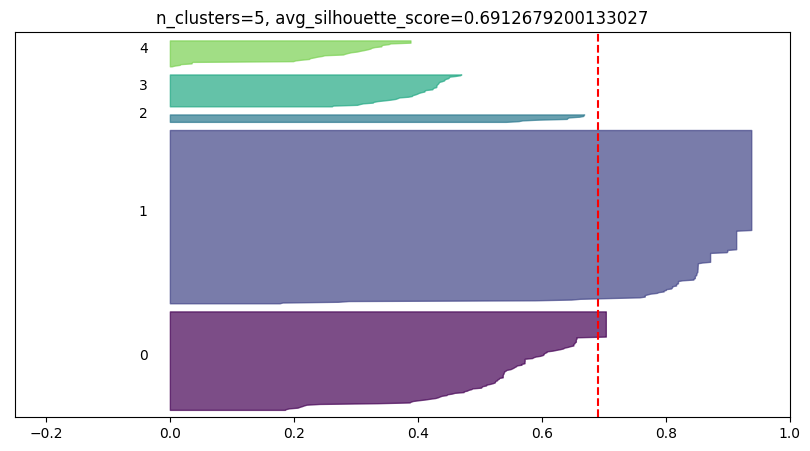

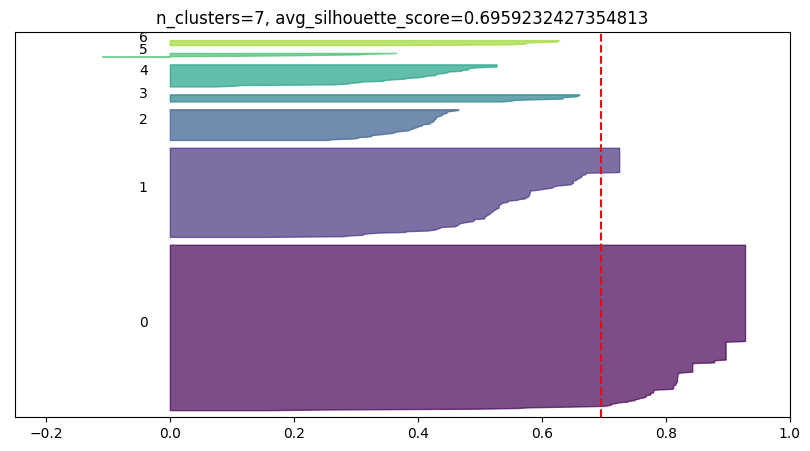

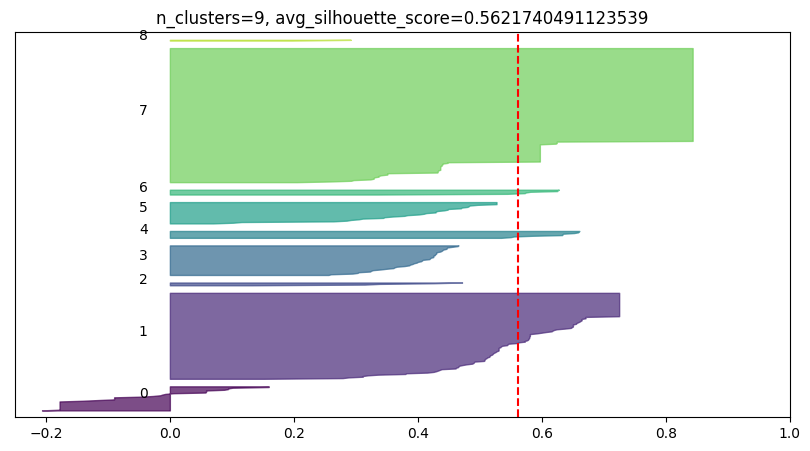

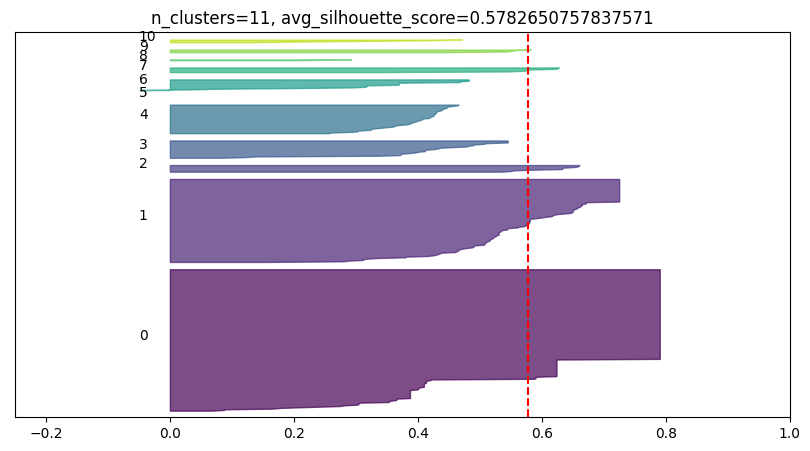

In [9]:
# Create a list to hold labels from all clustering attempts
clustering_data=[df_short[['MPS', 'Party']]]

for n_clusters in [2,3,4,5,7,9,11]:
    
    plt.figure(figsize=(10,5))
    plt.xlim([-.25,1])
    plt.ylim([0, df_short.shape[0] + (n_clusters + 1) * 10])
    # Initialize model and predict labels for a given n_clusters value
    model = KMeans(n_clusters=n_clusters, n_init=50, random_state=10)
    labels = pd.Series(model.fit_predict(df_short.iloc[:,2:]), name='clusters_{}_{}'.format(model.__class__.__name__, n_clusters))
    # Append labels to the list
    clustering_data.append(labels)
    # Compute both average and individual silhouette scores for each data point 
    silhouette_avg = silhouette_score(df_short.iloc[:,2:], labels)
    silhouette_values_samples = silhouette_samples(df_short.iloc[:,2:], labels)
    
    y_lower = 10
    for cluster in range(n_clusters):
        # Filter individual silhouette scores to get only those where labels match given cluster
        cluster_silhouette_values = silhouette_values_samples[labels == cluster]
        cluster_silhouette_values.sort()
        cluster_size = cluster_silhouette_values.shape[0]
        y_upper = y_lower + cluster_size
        # Plot scores of a given cluster
        color = cm.viridis(float(cluster) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        # Mark cluster number next to its scores
        plt.text(-0.05, y_lower + 0.5 * cluster_size, str(cluster))
        y_lower = y_upper + 10
    
    # Plot average silhouette score
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.title('n_clusters={}, avg_silhouette_score={}'.format(n_clusters, silhouette_avg))
    plt.yticks([])
    
# Create a dataframe containing labels from all clustering attempts
clustering_data = pd.concat(clustering_data, axis=1)
clustering_data.head()

Interestingly, the best defined clusters were achieved with n_clusters set to 3. Having more clusters resulted in a significant decrease in silhouette scores. Examining the cluster formed by the majority of opposition parties could help us formulate a strategy for future collaboration between these parties. It's worth mentioning that the individual silhouette scores in the cluster formed by the ruling party were significantly higher. This may suggest a higher level of unity within this group.

Below, you can observe how Members of Parliament (MPs) are grouped within the three clusters.

In [10]:
clustering_data.groupby('clusters_KMeans_3').value_counts(['Party'])

clusters_KMeans_3  Party       
0                  KO              126
                   Lewica           44
                   KP               24
                   Polska2050        8
                   Porozumienie      5
                   PPS               3
                   PS                2
                   niez.             1
1                  PiS             228
                   Kukiz15           4
                   niez.             3
                   PS                1
2                  Konfederacja     11
dtype: int64

Given that we have already fit the KMeans algorithm multiple times with various choices of *n_clusters*, it is certainly worthwhile to investigate how Members of Parliament are grouped when we set *n_clusters* to 11. This will allow us to determine whether the algorithm accurately recognizes voting strategies at a party level or if it identifies different patterns altogether. Therefore, we can further explore the characteristics of the resulting clusters and determine if they align with known political groupings or if they reveal new insights.

In [11]:
clustering_data.groupby('clusters_KMeans_11').value_counts(['Party'])

clusters_KMeans_11  Party       
0                   PiS             211
                    Kukiz15           3
1                   KO              126
2                   Konfederacja     11
3                   KP               24
                    PPS               3
4                   Lewica           44
5                   Kukiz15           1
6                   PiS              17
7                   Polska2050        8
8                   niez.             2
9                   Porozumienie      5
10                  PS                3
                    niez.             2
dtype: int64

One intriguing aspect of the grouping is that while the majority of parties have their own distinct cluster, three parties (PiS, Kukiz15, and niez.) are divided across multiple clusters. Additionally, there appear to be some minor alliances between certain groups. However, the question remains as to whether the 17 MPs from PiS whose views differ significantly enough to place them in a different cluster could potentially pose a threat to the party's unity in the future.

<a id='topics'></a>

## Identifying crucial topics that bind opposition parties

In this part of the analysis we'll focus on investigating which topics unify the opposition parties. Firstly we need to check what fraction of votings were unanimous for opposition, ruling parties and entire parliament. We will consider a voting to be unanimous when at least 90% of the group vote the same way.

Number of unanimous votings (ruling parties): 239, 99.58333333333333% out of all considered
Number of unanimous votings (opposition): 198, 82.5% out of all considered
Number of unanimous votings (entire parliament): 134, 55.833333333333336% out of all considered
Number of unanimous opposition votings (different vote from the rest of the parliament): 66


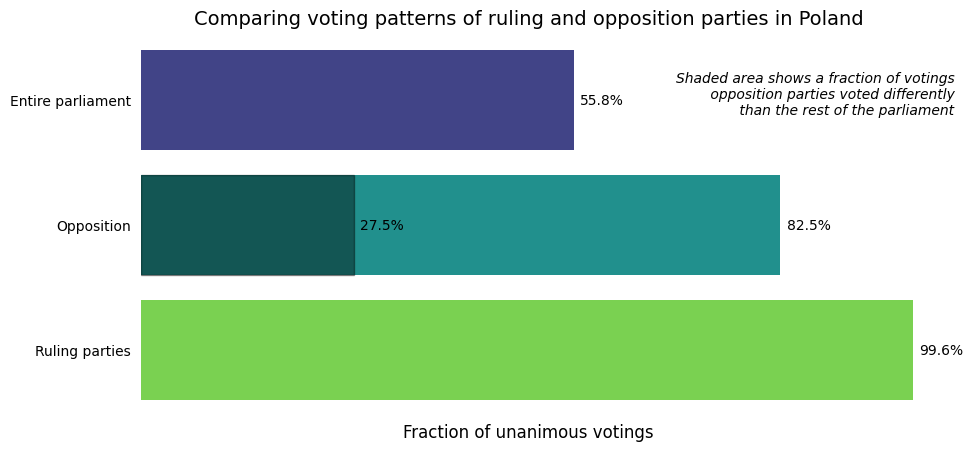

In [12]:
# Filter data only for ruling parties found in cluster 1
ruling_mask = clustering_data[clustering_data['clusters_KMeans_3']==1].index
ruling_df = df_short.iloc[ruling_mask, 2:]

# Check for voting sessions where ruling parties vote unanimously
ruling_unity = ruling_df.apply(lambda x: x.value_counts(), axis=0).apply(lambda x: x.max()/x.sum()>.9, axis=0)
rul_sum = ruling_unity.sum()
rul_unity_ind = ruling_unity[ruling_unity==True].index

# Filter data only for opposition parties found in cluster 0
opposition_mask = clustering_data[clustering_data['clusters_KMeans_3']==0].index
opposition_df = df_short.iloc[opposition_mask, 2:]

# Check for voting sessions where opposition parties vote unanimously
opposition_unity = opposition_df.apply(lambda x: x.value_counts(), axis=0).apply(lambda x: x.max()/x.sum()>.9, axis=0)
op_sum = opposition_unity.sum()
op_unity_ind = opposition_unity[opposition_unity==True].index

# Check for voting sessions where entire parliament votes unanimously
total_unity = df_short.iloc[:, 2:].apply(lambda x: x.value_counts(), axis=0).apply(lambda x: x.max()/x.sum()>.9, axis=0)
tot_sum = total_unity.sum()
total_unity_ind = total_unity[total_unity==True].index

# Check for voting sessions where opposition differs from the rest of the parliament
mask = ~op_unity_ind.isin(total_unity_ind)

all_votings = df_short.shape[1]-2

print(f'Number of unanimous votings (ruling parties): {rul_sum}, {rul_sum/(all_votings)*100}% out of all considered')
print(f'Number of unanimous votings (opposition): {op_sum}, {op_sum/(all_votings)*100}% out of all considered')
print(f'Number of unanimous votings (entire parliament): {tot_sum}, {tot_sum/(all_votings)*100}% out of all considered')
print(f'Number of unanimous opposition votings (different vote from the rest of the parliament): {mask.sum()}')

# Define data for the plot
values = [rul_sum, op_sum, tot_sum]
labels = ['Ruling parties', 'Opposition', 'Entire parliament']
colors = plt.cm.viridis_r([0.2, 0.5, 0.8])

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(labels, values, color=colors)

# Overlay the shaded area over the second bar
ax.barh(['Opposition'], [mask.sum()], color='black', alpha=.4, edgecolor='black')

# Settings
ax.set_title("Comparing voting patterns of ruling and opposition parties in Poland", fontsize=14)
ax.set_xlim(0, 240)
ax.set_xlabel('Fraction of unanimous votings', fontsize=12)
ax.tick_params(left=False, bottom=False, labelbottom=False)

# Add percentages next to the bars and shaded area
ax.text(mask.sum() + 2, 1, f'{mask.sum()/(df_short.shape[1]-2)*100:.1f}%', ha='left', va='center')
for i, v in enumerate(values):
    ax.text(v + 2, i, f'{v/(df_short.shape[1]-2)*100:.1f}%', ha='left', va='center')

# Add text in the top, right corner
text = "Shaded area shows a fraction of votings\n opposition parties voted differently\n than the rest of the parliament"
ax.text(1.05, 0.9, text, transform=ax.transAxes, ha='right', va='top', fontsize=10, fontstyle='italic')

# Remove spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Show the plot
plt.show()

In 198 out of 240 considered votings, the opposition (meaning all MPs grouped in cluster 0 - KO, Lewica, KP, Polska 2050 etc.) voted unanimously. However, it should be noted that in as many as 134 votings, the entire parliament was unanimous. We can assume that the remaining 66 votings, that differ opposition from ruling parties, somehow align with the opposition parties ideologically. Let's check the topics of these votings

In [13]:
topics = votes_info.loc[votes_info['vote_id'].isin(op_unity_ind[mask]), 'vote_topic']
for topic in topics[:10]:
    print(topic)

Pkt. 2 Pierwsze czytanie poselskiego projektu ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 2024 r. oraz o zmianie ustawy - Kodeks wyborczy (druk nr 2612) - wniosek o odrzucenie projektu w pierwszym czytaniu.
Pkt. 7 Sprawozdanie Komisji o pilnym rządowym projekcie ustawy o zasadach realizacji programów wsparcia przedsiębiorców w związku z sytuacją na rynku energii w latach 2022-2024 (druki nr 2616, 2621 i 2621-A) - głosowanie nad całością projektu.
Pkt. 10 Sprawozdanie Komisji o poselskim projekcie ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 2024 r. oraz o zmianie ustawy - Kodeks wyborczy (druki nr 2612 i 2635) - wniosek o odrzucenie w całości projektu.
Pkt. 10 Sprawozdanie Komisji o poselskim projekcie ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 2024 r. oraz o zmianie ustawy - Kodeks wyborczy (druki nr 2612 i 2635) - głosowanie nad całości

The volume of information contained in the text can be overwhelming. Therefore, it is essential to extract relevant keywords from the data. To achieve this, I propose using TfidfVectorizer with a custom tokenizer. This method helps bring all tokens to their base form, enabling more accurate analysis of the data. After analyzing the results, I found it necessary to add a few stop words to be omitted during the process.

In [14]:
def custom_tokenizer(document):
    # Get tokens with at least three letters, exclude digits 
    tokenizer = nltk.tokenize.RegexpTokenizer(r'(?u)\b[^\W\d]{3,}\b')
    tokens = tokenizer.tokenize(document)

    morf = morfeusz2.Morfeusz()
    # Get base form of each word and remove SGJP tag
    tokens = [morf.analyse(token)[0][2][1].split(':')[0] for token in tokens]

    return tokens

stop_words=['pierwszy', 'pierwsze', 'czytanie']

start = time.time()
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=.2).fit(topics)
end = time.time()

print('Fitting time: ', end-start)

start = time.time()
transformed_topics = tfidf.transform(topics)
end = time.time()

print('Transformation time: ', end-start)

/home/milosh-dr/code/MPs/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting time:  9.758314371109009
Transformation time:  12.501927852630615


The fitting and transformation process seems to be taking a considerable amount of time. However, since the current dataset is relatively small, this is not a major concern. Nonetheless, it is important to keep in mind that for larger corpora, this approach may not be scalable and one would need to consider alternative methods that are better suited for such scenarios.

Let's now have a look on the highest tfidf scores. 

In [15]:
names = tfidf.get_feature_names_out()
# Get most important features for each topic
for i, row in enumerate(transformed_topics[:10].toarray()):
    
    non_zeros = row[row.nonzero()]
    
    # Print original topics and labels
    print(topics.iloc[i])
    # Print top 5 most important features unless they all got the same importance score
    if np.all(non_zeros==non_zeros[0]):
        print(names[row.nonzero()])
    else:
        print(names[row.argsort()[-5:][::-1]])

    print('-'*30)

Pkt. 2 Pierwsze czytanie poselskiego projektu ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 2024 r. oraz o zmianie ustawy - Kodeks wyborczy (druk nr 2612) - wniosek o odrzucenie projektu w pierwszym czytaniu.
['samorząd' 'przedłużenie' 'kwietni' 'kadencja' 'jednostka']
------------------------------
Pkt. 7 Sprawozdanie Komisji o pilnym rządowym projekcie ustawy o zasadach realizacji programów wsparcia przedsiębiorców w związku z sytuacją na rynku energii w latach 2022-2024 (druki nr 2616, 2621 i 2621-A) - głosowanie nad całością projektu.
['pilny' 'program' 'lato' 'sytuacja' 'realizacja']
------------------------------
Pkt. 10 Sprawozdanie Komisji o poselskim projekcie ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 2024 r. oraz o zmianie ustawy - Kodeks wyborczy (druki nr 2612 i 2635) - wniosek o odrzucenie w całości projektu.
['samorząd' 'przedłużenie' 'kwietni' 'kadencja' 'jednostka']
-----

While analyzing data, it's crucial to ensure that the labels assigned to various features are informative and meaningful. However, it's often observed that some labels are more informative than others, and there is room for improvement in certain cases. Therefore, it's important to evaluate the relevance and significance of the labels assigned to different data points and consider re-labeling or refining them, if necessary.

To simplify our approach, we can utilize a regular expression pattern that is specifically tailored for the structure of our text data. This may allow us to achieve our goals more efficiently and with less computational cost than other techniques.

In [21]:
# The regular expression pattern is used to extract information about the legislations being voted on in the dataset.
# It searches for the word 'ustawy' followed by an optional '-' or 'o', then some text before either 'oraz' or '('.
# This approach ensures we have all the legislations being voted on, including those that are voted on together and those voted on separately.

extracted = topics.str.extract(r"ustawy\s*(?:[-o]\s)?(.*)(?=oraz)oraz\s*(?:[-o]\s)?(.*)(?=\s*\()|ustawy\s*(?:[-o]\s)?(.*)(?=\s*\()")
# Combine data into a single column and clean it using regular expressions
as_series = []
for col in extracted.columns:
    as_series.append(extracted[col].dropna())
extracted = (pd.concat(as_series, axis=0)
            .str.replace(r'.*ustawy\s*[-o]\s', '', regex=True)
            .str.replace(r'.*niektórych.*', 'Inne ustawy', regex=True)
            .drop_duplicates())

print("Unique topics:", len(extracted))
extracted[:10]

Unique topics: 33


3      przedłużeniu kadencji organów jednostek samorz...
71                          gospodarce nieruchomościami 
116    wyrobie napojów spirytusowych oraz o rejestrac...
124                              Prawo o ruchu drogowym 
352                                  Służbie Więziennej 
451                               finansach publicznych 
560                         Kodeks postępowania karnego 
616                                   Karta Nauczyciela 
679                     działach administracji rządowej 
706    inwestycjach w zakresie terminalu regazyfikacy...
dtype: object

After extracting the legislation names using regular expressions, we obtained a list of names that might contain spelling mistakes or variations in the word forms. Unfortunately, it is not feasible to correct all these variations due to the complexity of the Polish language grammar. To achieve cleaner result, one could develop a spelling correction model based on external data. However, we will leave this task for future development as our current focus is on exploring the dataset and identifying patterns and topics themselves.

In my opinion, the legislation names are more informative for the opposition parties to remind them of their unified voting strategy than the keywords obtained in the first approach. However, for further development, one could consider modeling topics using not only legislation names but also their texts. This would provide more context and insights into the actual content of the legislation being voted on.